In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pip install ultralytics==8.2.0    ### ==8.0.196, 8.1.0
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.0 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Setup complete ✅ (12 CPUs, 53.0 GB RAM, 33.0/201.2 GB disk)


In [ ]:
from ultralytics import YOLO
import cv2
import sys
import numpy as np
import os
from shapely.geometry import Polygon
from PIL import Image, ImageDraw
from sklearn.metrics import auc

HOME = os.getcwd()
print(HOME)

!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device="cuda")
predictor = SamPredictor(sam)

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-x6trfb5z
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-x6trfb5z
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
--2024-06-18 21:45:24--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.155.173.116, 18.155.173.79, 18.155.173.80, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.155.173.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.1’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   130MB/s    in 19s     

2024-06-18 21:45:43 (128 MB/s) - ‘sam_vit_h_4b8939.pth.1’ saved [2564550879/256

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="lTCFwgU77wetqLzIEXul")
project = rf.workspace("s-7ipqq").project("weed-detection-k4z6s")
version = project.version(3)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


KeyboardInterrupt: 

In [ ]:
def parse_annotation(txt_file, image_shape):
    height, width = image_shape[:2]
    with open(txt_file, 'r') as file:
        polygons = []
        for line in file:
            parts = line.strip().split()
            coords = list(map(float, parts[1:]))
            points = [(coords[i] * width, coords[i + 1] * height) for i in range(0, len(coords), 2)]
            polygons.append(Polygon(points))
    return polygons

def polygons_to_mask(polygons, image_shape):
    height, width = image_shape[:2]
    mask = Image.new('L', (width, height), 0)
    for polygon in polygons:
        ImageDraw.Draw(mask).polygon(list(polygon.exterior.coords), outline=1, fill=1)
    return np.array(mask)

def calculate_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    iou = intersection / union if union != 0 else 0
    return iou

def calculate_precision_recall(iou_scores, iou_threshold=0.5):
    true_positives = sum(iou >= iou_threshold for iou in iou_scores)
    false_positives = sum(iou < iou_threshold for iou in iou_scores)
    false_negatives = 0

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives != 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives != 0 else 0

    return precision, recall

models = [YOLO('/content/drive/MyDrive/ZeroX400/weights/best.pt')]

image_folders = ['/content/weed-detection-3/valid/images']

gt_folders = ['/content/weed-detection-3/valid/labels']

for i in range(1):
  model = models[i]
  image_folder = image_folders[i]
  gt_folder = gt_folders[i]
  print('i:', i)

  iou_scores = []

  for image_filename in os.listdir(image_folder):
      # print('image_filename:', image_filename)

      if image_filename.lower().endswith(('.png', '.jpg', '.jpeg')):
          image_path = os.path.join(image_folder, image_filename)
          gt_path = os.path.join(gt_folder, os.path.splitext(image_filename)[0] + '.txt')

          if not os.path.exists(gt_path):
              print(f"Ground truth annotation for {image_filename} not found, skipping...")
              continue

          image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

          polygons = parse_annotation(gt_path, image.shape)
          gt_mask = polygons_to_mask(polygons, image.shape)

          results = model.predict(source=image_path, conf=0.25)

          all_boxes = []
          for result in results:
              boxes = result.boxes
              all_boxes.extend(boxes.xyxy.tolist())

          predictor.set_image(image)

          for bbox in all_boxes:
              input_box = np.array(bbox)

              masks, _, _ = predictor.predict(
                  point_coords=None,
                  point_labels=None,
                  box=input_box[None, :],
                  multimask_output=False,
              )

              pred_mask = masks[0]
              if pred_mask.shape != gt_mask.shape:
                  pred_mask = cv2.resize(pred_mask, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

              iou = calculate_iou(pred_mask, gt_mask)
              iou_scores.append(iou)

  iou_thresholds = np.linspace(0.5, 0.95, 50)

  precisions = []
  recalls = []

  for iou_threshold in iou_thresholds:
      precision, recall = calculate_precision_recall(iou_scores, iou_threshold)
      precisions.append(precision)
      recalls.append(recall)

  precision_recall_auc = auc(recalls, precisions)

  print(f"Precisions: {precisions}")
  print(f"Recalls: {recalls}")
  print(f"mAP: {precision_recall_auc:.4f}")


i: 0

image 1/1 /content/weed-detection-3/valid/images/DJI_20231009115106_0171_D_JPG.rf.84195ec5c2f6687d946630d18dedf6a6.jpg: 416x512 3 weedss, 15.4ms
Speed: 1.2ms preprocess, 15.4ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 512)

image 1/1 /content/weed-detection-3/valid/images/DJI_20231009115630_0333_D_JPG.rf.7e69220dd7390e6728e12303e03c3448.jpg: 416x512 4 weedss, 16.4ms
Speed: 0.9ms preprocess, 16.4ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 512)

image 1/1 /content/weed-detection-3/valid/images/DJI_20231009115112_0174_D_JPG.rf.073c82b8ff92ae37517c919c22a61a69.jpg: 416x512 3 weedss, 16.1ms
Speed: 1.0ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 512)

image 1/1 /content/weed-detection-3/valid/images/DJI_20231009113904_0049_D_JPG.rf.935f264d250369f7f2780579dc1a02be.jpg: 416x512 22 weedss, 16.0ms
Speed: 0.9ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 512)

image 1/1 /content/we


image 1/1 /content/weed-detection-3/test/images/DJI_20231009121108_0771_D_JPG.rf.c1eef56abf738eaeccdd71581c3a5e5c.jpg: 416x512 5 weedss, 20.8ms
Speed: 1.1ms preprocess, 20.8ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 512)


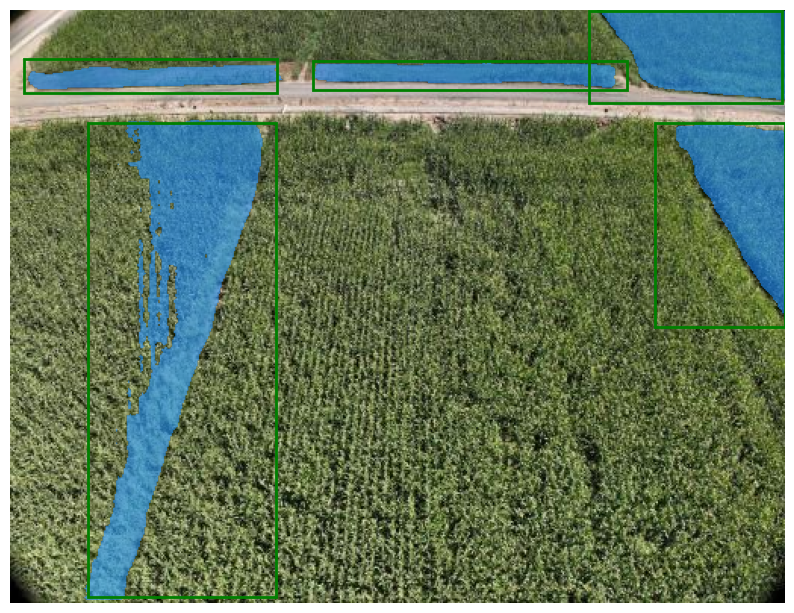


image 1/1 /content/weed-detection-3/test/images/DJI_20231009121108_0771_D_JPG.rf.c1eef56abf738eaeccdd71581c3a5e5c.jpg: 416x512 8 weedss, 7.6ms
Speed: 1.0ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 512)


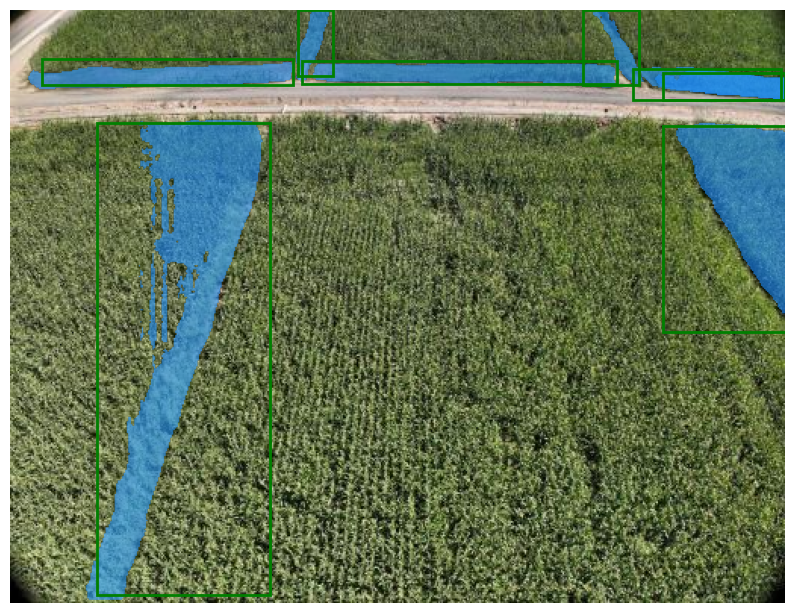

In [ ]:
import matplotlib.pyplot as plt

results = model.predict(source='/content/weed-detection-3/valid/images/DJI_20231009113926_0060_D_JPG.rf.dc3bf1ba0632d245d58be8c9b0bc8d7b.jpg', conf=0.27)

for model in models:

  all_boxes = []
  for result in results:
      boxes = result.boxes
      all_boxes.extend(boxes.xyxy.tolist())

  image_path = '/content/datasets160/weed-detection-8/test/images/DJI_20231009113924_0059_D_JPG.rf.2171e1cddd0d78293d8b6f545d8adcd3.jpg'
  image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
  predictor.set_image(image)

  def show_mask(mask, ax, random_color=False):
      if random_color:
          color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
      else:
          color = np.array([30/255, 144/255, 255/255, 0.6])
      h, w = mask.shape[-2:]
      mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
      ax.imshow(mask_image)

  def show_box(box, ax):
      x0, y0 = box[0], box[1]
      w, h = box[2] - box[0], box[3] - box[1]
      ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

  plt.figure(figsize=(10, 10))
  plt.imshow(image)
  for bbox in all_boxes:
      input_box = np.array(bbox)

      # Predict mask for the current bounding box
      masks, _, _ = predictor.predict(
          point_coords=None,
          point_labels=None,
          box=input_box[None, :],
          multimask_output=False,
      )

      # Show the mask and bounding box
      show_mask(masks[0], plt.gca())
      show_box(input_box, plt.gca())

  plt.axis('off')
  plt.show()

In [ ]:
!yolo task=segment mode=predict model=/content/drive/MyDrive/best.pt conf=0.25 source=/content/datasets400/weed-detection-3/valid/images/DJI_20231009114625_0031_D_JPG.rf.f1534ca3316b6c98e47c533bf540336a.jpg save=true
!yolo task=segment mode=predict model=/content/drive/MyDrive/160Instance/weights/best.pt conf=0.25 source=/content/datasets400/weed-detection-3/valid/images/DJI_20231009114625_0031_D_JPG.rf.f1534ca3316b6c98e47c533bf540336a.jpg save=true
!yolo task=segment mode=predict model=/content/drive/MyDrive/130Instance/weights/best.pt conf=0.25 source=/content/datasets400/weed-detection-3/valid/images/DJI_20231009114625_0031_D_JPG.rf.f1534ca3316b6c98e47c533bf540336a.jpg save=true
!yolo task=segment mode=predict model=/content/drive/MyDrive/100Instance/weights/best.pt conf=0.25 source=/content/datasets400/weed-detection-3/valid/images/DJI_20231009114625_0031_D_JPG.rf.f1534ca3316b6c98e47c533bf540336a.jpg save=true
!yolo task=segment mode=predict model=/content/drive/MyDrive/75Instance/weights/best.pt conf=0.25 source=/content/datasets400/weed-detection-3/valid/images/DJI_20231009114625_0031_D_JPG.rf.f1534ca3316b6c98e47c533bf540336a.jpg save=true
!yolo task=segment mode=predict model=/content/drive/MyDrive/50Instance/weights/best.pt conf=0.25 source=/content/datasets400/weed-detection-3/valid/images/DJI_20231009114625_0031_D_JPG.rf.f1534ca3316b6c98e47c533bf540336a.jpg save=true
!yolo task=segment mode=predict model=/content/drive/MyDrive/30Instance/weights/best.pt conf=0.25 source=/content/datasets400/weed-detection-3/valid/images/DJI_20231009114625_0031_D_JPG.rf.f1534ca3316b6c98e47c533bf540336a.jpg save=true
!yolo task=segment mode=predict model=/content/drive/MyDrive/20Instance/weights/best.pt conf=0.25 source=/content/datasets400/weed-detection-3/valid/images/DJI_20231009114625_0031_D_JPG.rf.f1534ca3316b6c98e47c533bf540336a.jpg save=true
!yolo task=segment mode=predict model=/content/drive/MyDrive/10Instance/weights/best.pt conf=0.25 source=/content/datasets400/weed-detection-3/valid/images/DJI_20231009114625_0031_D_JPG.rf.f1534ca3316b6c98e47c533bf540336a.jpg save=true